In [11]:
using Revise
ENV["GKS_ENCODING"]="utf-8"

using LinearAlgebra, Statistics, Rotations, ProgressMeter, Random, JLD2, BenchmarkTools, StaticArrays, Dates, FileIO, Colors, NearestNeighbors, Distances, Distributions, Combinatorics, Dates, StatsBase, DelimitedFiles, DataStructures, SpecialFunctions, StatsFuns, Interpolations, Glob, IterTools, Clustering, Optim, Suppressor, ThreadsX, ColorSchemes, Accessors, DSP, NaNMath, DataFrames, HDF5

BLAS.set_num_threads(4)

using GLMakie
using CairoMakie
gl(args...; kwargs...) = GLMakie.activate!(args...; kwargs...);
cairo(args...; kwargs...) = CairoMakie.activate!(args...; kwargs...);
set_window_config!(float=false);
ProgressMeter.ijulia_behavior(:clear)

theme = Theme(Volume = (algorithm = :iso, isovalue = 1.0, isorange = 0.9, colorrange = (0, 2)))
set_theme!(theme)

┌ Warning: Module SortingAlgorithms with build ID fafbfcfd-a2b2-85c8-0000-0872b66244a8 is missing from the cache.
│ This may mean SortingAlgorithms [a2af1166-a08f-5f64-846c-94a0d3cef48c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module DataFrames with build ID ffffffff-ffff-ffff-001f-f13b377fa61a is missing from the cache.
│ This may mean DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module Transducers with build ID fafbfcfd-d90f-8f8e-001f-ed83de7d8f1d is missing from the cache.
│ This may mean Transducers [28d57a85-8fef-5791-bfe6-a80928e7c999] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module DataStructures with build ID fafbfcfd-62c1-973d-0000-08724d8405b2 is missing from the cache.
│ This may mean DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cf

In [12]:
using CUDA
CUDA.allowscalar(false)
import NPhotons as nph
includet("utils.jl")

┌ Warning: Module DataStructures with build ID fafbfcfd-62c1-973d-0000-08724d8405b2 is missing from the cache.
│ This may mean DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module DataFrames with build ID ffffffff-ffff-ffff-001f-f13b377fa61a is missing from the cache.
│ This may mean DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module DataStructures with build ID fafbfcfd-62c1-973d-0000-08724d8405b2 is missing from the cache.
│ This may mean DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
┌ Warning: Module Graphs with build ID ffffffff-ffff-ffff-001f-f14884591b66 is missing from the cache.
│ This may mean Graphs [86223c79-3864-5bf0-83f7-82e725a168b6] does not sup

In [13]:
photoncounts = @showprogress map(glob("out/images/coliphage/*.h5")) do path
    p = h5open(path, "r") do fid
        fid["photonConverter"]["pnccdBack"]["photonCount"][]
    end
    [Int.(p[:,:,i]) for i in axes(p, 3)]
end
photoncounts = reduce(vcat, photoncounts);

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [5]:
edgelimit = 0.0086*2pi
dxs = range(-edgelimit, edgelimit, length = size(photoncounts[1], 1))
dys = range(-edgelimit, edgelimit, length = size(photoncounts[1], 2))
dpixels = [SA[x, y, 0] for x in dxs, y in dys];
dpixelWeights = sum(photoncounts) .> 0;

In [109]:
images = @showprogress map(sample(photoncounts, 1000, replace = false)) do p
# images = @showprogress map(photoncounts) do p
    l = rand(Binomial(sum(p), 1e-4))
    sample(dpixels, Weights(reshape(p, :)), l)
end;
qmin = 0
qmax = 0.05
images = filter.(x -> qmin < norm(x) < qmax, images);
images = [image[1:min(end, 300)] for image in images];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


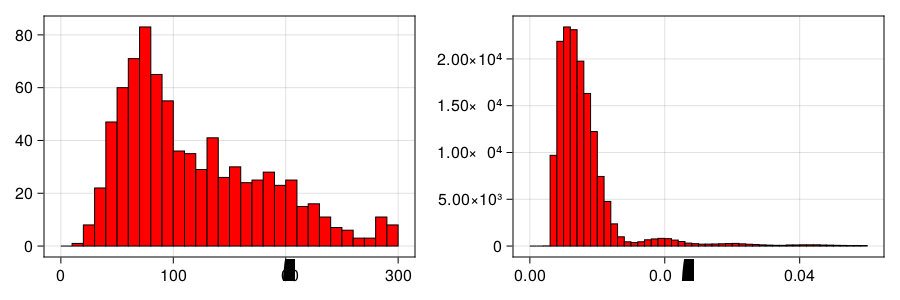

In [111]:
cairo(); fig = Figure(resolution = (900, 300)); ax1 = Axis(fig[1,1]); ax2 = Axis(fig[1,2])
rs = 0:0.001:qmax
hist!(ax1, length.(images), bins=0:10:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist!(ax2, norm.(reduce(vcat, images)), bins=rs, color=:red, strokewidth=1, strokecolor=:black)
fig

In [112]:
o = nph.AtomVolume([[SA[0.0,0.0,0.0]]; 215 .* nph.getIcosphereVerts(0)], 70, 200)
o = nph.normalizeScattering(o, qmax = qmax, nphotons = 1)
n = nph.AtomVolume(1, 1/0.02, 1)
n = nph.normalizeScattering(n, qmax = qmax, nphotons = 0.05)
object = nph.MixtureVolume(o, n);

In [113]:
npercircle = 32
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = qmax / 30, qmax = qmax, npercircle = npercircle, wavelength = 2.5)

inds = nph.roundImages(pixels[:], [dpixels[:]])[1]
pixelWeights .= 0
for i in 1:length(inds)
    if norm(dpixels[i]) < qmax
        pixelWeights[inds[i]] += dpixelWeights[i]
    end
end
pixelWeights .*= [1 - ifelse(p[1] == 0, 0.0, (15p[2])^2) for p in pixels]

itp = linear_interpolation((dxs, dys), dpixelWeights)
pixelWeights .*= [itp(p[1], p[2]) for p in pixels]

normalize!(pixelWeights, 1)

# rotations, rotationWeights = nph.uniformRotationGrid(precision = 7, npercircle = npercircle);
# params = (; pixels, pixelWeights=reshape(pixelWeights,:,1), rotations, rotationWeights, npercircle = npercircle);
# logp = nph.logpClosure(images, params, 1, ncalls = 1, inner = false, mode = :normalized);

rotations, rotationWeights = nph.rotationGrid(precision = 47)

npixelWeights = zeros(length(pixelWeights), npercircle)
for i in 0:npercircle-1
    circshift!(view(reshape(npixelWeights, npercircle, :, npercircle),:,:,i+1), reshape(pixelWeights, npercircle, :), (i, 0))
end
params = (; pixels, pixelWeights=npixelWeights, rotations, rotationWeights, npercircle = npercircle);
logp = nph.logpClosure(images, params, 1, inner = true, ncalls = 1, mode = :normalized);

In [114]:
CUDA.@time logp(object)

  0.028869 seconds (921 CPU allocations: 113.156 KiB) (21 GPU allocations: 9.236 MiB, 0.45% memmgmt time)


394130.7296817561

In [77]:
gl(); window(scatter(Ref(rotations[end]) .* pixels, markersize = 10normalize(npixelWeights[:,2], Inf))); focus()

In [115]:
nc = 1
f = nph.normalizeScattering(nph.randomAtomVolume(13, 70, 200), qmax = qmax, nphotons = 1)
c = ([nph.MixtureVolume(deepcopy(f), n) for _ in 1:nc], normalize(ones(nc), 1))


proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.MultiProposer(
        [nph.GibbsProposer(nph.CombinedProposer(nph.StructureProposer(150.0), nph.WidthProposer(0)), 1) for i in 1:nc]), 1), 
        stepsize = 10.0, stepmax = 100.0), 
    nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(Erlang(20, 0.5/20)), 2), stepmax = 1.0)
)

state = nph.Annealer(c, proposers, temperature = 1e3, thalf = 1e4, histstep = 1);

In [116]:
gl(); fig = Figure(resolution = (1600, 2000))

node = Observable(state)

ax1 = Axis(fig[2:3,1:nc][1, 1])
lines!(ax1, lift(x -> x.energies, node))
ax2 = Axis(fig[2:3,1:nc][1, 2])
ax3 = Axis(fig[2:3,1:nc][2, 1])
ax4 = Axis(fig[2:3,1:nc][2, 2])
for i in 1:nc
    lines!(ax2, lift(x -> [mean(norm, h[1][i][1].positions) for h in x.history], node))
    lines!(ax3, lift(x -> [normalize(h[2], 1)[i] for h in x.history], node))
    lines!(ax4, lift(x -> [h[1][i][1].widths[1] for h in x.history], node))
end
hlines!(ax3, [0, 1], color = :transparent)
on(s -> (autolimits!(ax1); autolimits!(ax2); autolimits!(ax3); autolimits!(ax4)), node);

for i in 1:nc
    ls = LScene(fig[1,i], show_axis=false); Camera3D(ls.scene);
    volume!(ls, lift(x -> x.configuration[1][i][1], node), algorithm = :iso)
    scatter!(ls, lift(x -> x.configuration[1][i][1].positions, node), markersize = 30, markerspace = :data, overdraw = true)
end

linkCameras!(contents(fig[1, 1:end]))

window(fig); focus()

In [117]:
function outfunc()
    t = now()
    function func(states)
        if now() - t > Second(1)
            node[] = states
            t = now()
        end
        !ispressed(fig, Keyboard.escape)
    end
end

nph.anneal!(state, nph.multienergy(logp, offset = -logp(object)), output = outfunc(), minTemp=1.0, nsteps = nph.remainingSteps(state) + 1000);

Progress:   1%|▎                          |  ETA: 1:27:59 (52.93 ms/it)
  stepsizes:    [100.0, 0.28]
  temperature:  938.5464155421581
  nsteps:       915/100658
  accepted:     [0.31, 0.23]
  energy:       6386.421414015